In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
pd.set_option('display.max_columns', None)

In [53]:
#NFL Colors
nfl_red = "#D50A0A"  # NFL red
nfl_blue = "#013369"  # Official NFL blue

In [4]:
uploaded = files.upload()

Saving aggregated_final_df.csv to aggregated_final_df.csv


In [165]:
aggregated_final_df = pd.read_csv('aggregated_final_df.csv')
print(aggregated_final_df.shape)

(16062, 35)


In [166]:
# Define the variables to check
variables = ['rb_snap_motion', 'fb_snap_motion', 'te_snap_motion', 'wr_snap_motion']

# Filter the DataFrame to keep only rows where at most one variable is equal to 1
# Penalty to have more than one person in motion when the ball is snapped
aggregated_final_df = aggregated_final_df[aggregated_final_df[variables].sum(axis=1) <= 1]

# Display the result
print(aggregated_final_df.shape)

(16001, 35)


In [138]:
print(aggregated_final_df.head())
print(aggregated_final_df.columns)

       gameId  playId  rb_snap_motion  fb_snap_motion  wr_snap_motion  \
0  2022090800      56               0               0               0   
1  2022090800      80               1               0               0   
2  2022090800     101               0               1               0   
3  2022090800     122               0               0               0   
4  2022090800     167               0               0               0   

   te_snap_motion  rb_shift  fb_shift  wr_shift  te_shift  qb_shift  \
0               0         0         0         0         0         0   
1               0         0         0         0         0         0   
2               0         0         0         0         0         0   
3               0         0         0         0         0         0   
4               0         0         0         0         0         0   

   rb_motion  fb_motion  wr_motion  te_motion  qb_depth  rb_depth  fb_depth  \
0          0          0          1          0  0.906506

In [139]:
# Create motion type groups based on specified variables
aggregated_final_df['Shift'] = (
    'RB:' + aggregated_final_df['rb_shift'].astype(str) +
    ' | FB:' + aggregated_final_df['fb_shift'].astype(str) +
    ' | WR:' + aggregated_final_df['wr_shift'].astype(str) +
    ' | TE:' + aggregated_final_df['te_shift'].astype(str)
)

aggregated_final_df['Motion Pre-Snap'] = (
    'RB:' + aggregated_final_df['rb_motion'].astype(str) +
    ' | FB:' + aggregated_final_df['fb_motion'].astype(str) +
    ' | WR:' + aggregated_final_df['wr_motion'].astype(str) +
    ' | TE:' + aggregated_final_df['te_motion'].astype(str)
)

aggregated_final_df['Motion at Snap'] = (
    'RB:' + aggregated_final_df['rb_snap_motion'].astype(str) +
    ' | FB:' + aggregated_final_df['fb_snap_motion'].astype(str) +
    ' | WR:' + aggregated_final_df['wr_snap_motion'].astype(str) +
    ' | TE:' + aggregated_final_df['te_snap_motion'].astype(str)
)

# Group by each motion type and calculate probabilities for run and pass plays
motion_types = ['Shift', 'Motion Pre-Snap', 'Motion at Snap']
motion_combined = []

for motion_type in motion_types:
    motion_data = (
        aggregated_final_df.groupby(motion_type)[['target_rush']]
        .mean()
        .reset_index()
        .rename(columns={motion_type: 'motion_type'})
    )
    motion_data['run_probability'] = motion_data['target_rush']  # Run probability
    motion_data['pass_probability'] = 1 - motion_data['target_rush']  # Pass probability
    motion_data['category'] = motion_type  # Add a category column for motion type
    motion_combined.append(motion_data)

# Combine all motion types into one DataFrame
motion_combined_df = pd.concat(motion_combined, ignore_index=True)

# Sort by run_probability in descending order for better visualization
motion_combined_df = motion_combined_df.sort_values(by='run_probability', ascending=False)

# Display the updated DataFrame for verification
print(motion_combined_df.head())

                  motion_type  target_rush  run_probability  pass_probability  \
6   RB:0 | FB:1 | WR:1 | TE:0     1.000000         1.000000          0.000000   
7   RB:0 | FB:1 | WR:1 | TE:1     1.000000         1.000000          0.000000   
23  RB:0 | FB:1 | WR:1 | TE:1     1.000000         1.000000          0.000000   
14  RB:1 | FB:1 | WR:1 | TE:0     1.000000         1.000000          0.000000   
5   RB:0 | FB:1 | WR:0 | TE:1     0.842105         0.842105          0.157895   

           category  
6             Shift  
7             Shift  
23  Motion Pre-Snap  
14            Shift  
5             Shift  


In [140]:
# Add play_count column by counting the number of plays for each motion type and category
motion_combined_with_counts = []

for motion_type in motion_types:
    motion_data = (
        aggregated_final_df.groupby(motion_type)[['target_rush']]
        .agg(target_rush_mean=('target_rush', 'mean'), play_count=('target_rush', 'size'))  # Add play_count
        .reset_index()
        .rename(columns={motion_type: 'motion_type'})
    )
    motion_data['run_probability'] = motion_data['target_rush_mean']  # Run probability
    motion_data['pass_probability'] = 1 - motion_data['target_rush_mean']  # Pass probability
    motion_data['category'] = motion_type  # Add a category column for motion type
    motion_combined_with_counts.append(motion_data)

# Combine all motion types into one DataFrame
motion_combined_df = pd.concat(motion_combined_with_counts, ignore_index=True)

# Sort by run_probability in descending order for better visualization
motion_combined_df = motion_combined_df.sort_values(by='run_probability', ascending=False)

# Display the updated DataFrame for verification
print(motion_combined_df.groupby(['motion_type']).mean('target_rush_mean').sort_values(by='play_count', ascending=False))


                           target_rush_mean    play_count  run_probability  \
motion_type                                                                  
RB:0 | FB:0 | WR:0 | TE:0          0.417478  11939.000000         0.417478   
RB:0 | FB:0 | WR:1 | TE:0          0.455463   1834.333333         0.455463   
RB:0 | FB:0 | WR:0 | TE:1          0.512091   1103.333333         0.512091   
RB:1 | FB:0 | WR:0 | TE:0          0.315611    647.333333         0.315611   
RB:0 | FB:1 | WR:0 | TE:0          0.567423    171.666667         0.567423   
RB:0 | FB:0 | WR:1 | TE:1          0.519327    161.000000         0.519327   
RB:1 | FB:0 | WR:1 | TE:0          0.154226    107.000000         0.154226   
RB:1 | FB:0 | WR:0 | TE:1          0.260515    101.000000         0.260515   
RB:1 | FB:0 | WR:1 | TE:1          0.223389     46.500000         0.223389   
RB:0 | FB:1 | WR:0 | TE:1          0.643275     18.500000         0.643275   
RB:0 | FB:1 | WR:1 | TE:0          0.791667      8.500000       

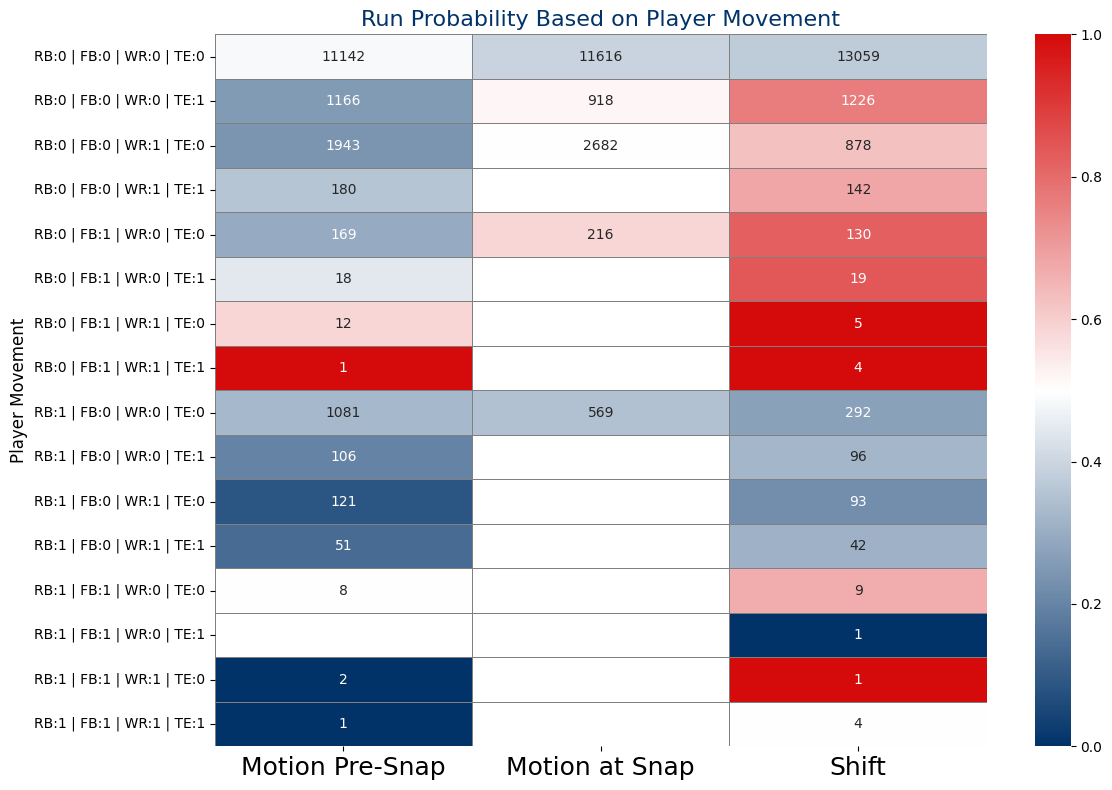

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom divergent colormap
cmap = mcolors.LinearSegmentedColormap.from_list("nfl_divergent", [nfl_blue, "white", nfl_red])

# Reshape the DataFrame for the heatmap
heatmap_data = motion_combined_df.pivot(
    index='motion_type', columns='category', values='run_probability'
)

# Create a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=motion_combined_df.pivot(index='motion_type', columns='category', values='play_count'),  # Annotate play count
    fmt='.0f',  # Format play counts as integers
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray'
)

# Add titles and labels
plt.title('Run Probability Based on Player Movement', fontsize=16, color= nfl_blue)
plt.xlabel(None)
plt.ylabel('Player Movement', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()


In [79]:
# Group by offensive formation and calculate average target_rush
formation_analysis = aggregated_final_df.groupby('offenseFormation')[['target_rush']].mean().reset_index()

# Calculate run and pass probabilities
formation_analysis['run_probability'] = formation_analysis['target_rush']
formation_analysis['pass_probability'] = 1 - formation_analysis['target_rush']

# Sort by run probability for better visualization
formation_analysis = formation_analysis.sort_values('run_probability', ascending=False)
print(formation_analysis)

  offenseFormation  target_rush  run_probability  pass_probability
2            JUMBO     0.840000         0.840000          0.160000
6          WILDCAT     0.833333         0.833333          0.166667
1           I_FORM     0.723301         0.723301          0.276699
5       SINGLEBACK     0.680616         0.680616          0.319384
3           PISTOL     0.675039         0.675039          0.324961
4          SHOTGUN     0.285127         0.285127          0.714873
0            EMPTY     0.070359         0.070359          0.929641


In [82]:
print(aggregated_final_df['receiverAlignment'].value_counts())

receiverAlignment
2x2    6442
3x1    6004
2x1    1808
3x2    1216
1x1     155
4x1     125
2x0      45
3x0       9
1x0       8
3x3       1
Name: count, dtype: int64


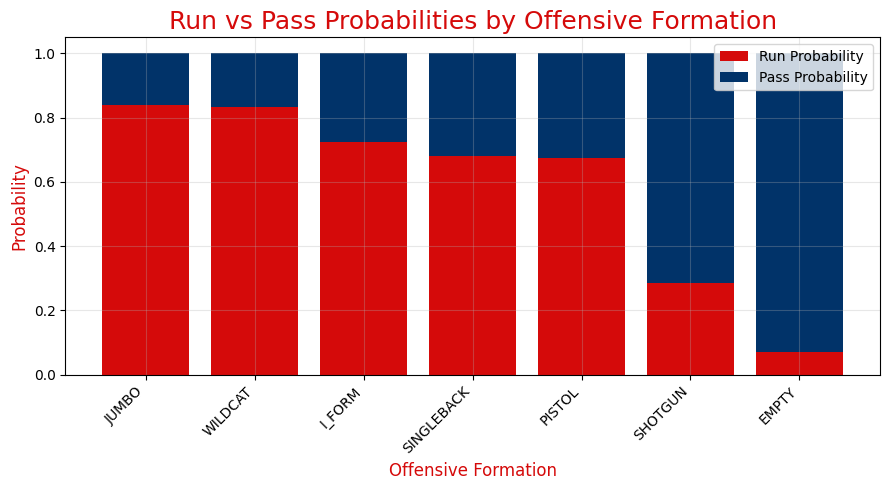

In [78]:
plt.figure(figsize=(9, 5))
# Visualize probabilities
plt.bar(
    formation_analysis['offenseFormation'],
    formation_analysis['run_probability'],
    color=nfl_red,
    alpha=1.0,  # Solid red
    label='Run Probability'
)
plt.bar(
    formation_analysis['offenseFormation'],
    formation_analysis['pass_probability'],
    bottom=formation_analysis['run_probability'],
    color=nfl_blue,
    alpha=1.0,  # Solid blue
    label='Pass Probability'
)

# Add titles and labels
plt.title('Run vs Pass Probabilities by Offensive Formation', fontsize=18, color=nfl_red)
plt.xlabel('Offensive Formation', fontsize=12, color=nfl_red)
plt.ylabel('Probability', fontsize=12, color=nfl_red)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# Define the relevant columns for analysis
analysis_columns = [
    'down', 'yardsToGo', 'offenseFormation', 'receiverAlignment',
    'rb_depth', 'target_rush'
]

# Filter dataset
updated_data = aggregated_final_df[analysis_columns]

In [85]:
# Analyze 'down' and 'yardsToGo' impact on play type (rush probability)
down_distance_analysis = updated_data.groupby(['down', 'yardsToGo'])['target_rush'].mean().reset_index()
down_distance_analysis.rename(columns={'target_rush': 'avg_rush_probability'}, inplace=True)

# Analyze offensive formations' correlation with rushing play
formation_analysis = updated_data.groupby('offenseFormation')['target_rush'].mean().reset_index()
formation_analysis.rename(columns={'target_rush': 'avg_rush_probability'}, inplace=True)

# Analyze wide receiver alignments' impact on rushing play
alignment_analysis = updated_data.groupby('receiverAlignment')['target_rush'].mean().reset_index()
alignment_analysis.rename(columns={'target_rush': 'avg_rush_probability'}, inplace=True)

# Analyze running back depth impact on rushing play
rb_depth_analysis = updated_data.groupby('rb_depth')['target_rush'].mean().reset_index()
rb_depth_analysis.rename(columns={'target_rush': 'avg_rush_probability'}, inplace=True)

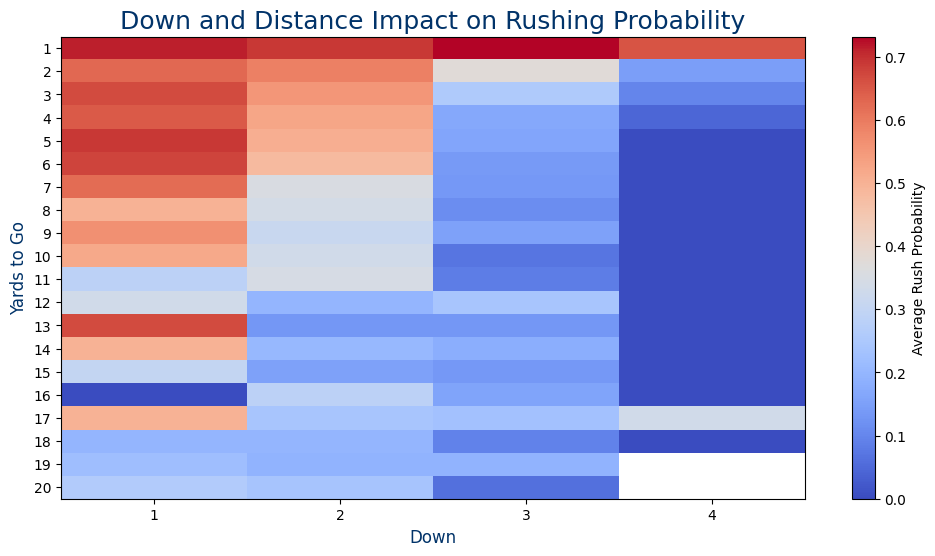

In [172]:
#Down and Distance Impact Analysis
down_distance_pivot = down_distance_analysis.pivot(index='yardsToGo', columns='down', values='avg_rush_probability')
plt.figure(figsize=(12, 6))
plt.imshow(
    down_distance_pivot,
    cmap='coolwarm',
    aspect='auto'
)
plt.colorbar(label='Average Rush Probability')

plt.title('Down and Distance Impact on Rushing Probability', fontsize=18, color=nfl_blue)
plt.xlabel('Down', fontsize=12, color=nfl_blue)
plt.ylabel('Yards to Go', fontsize=12, color=nfl_blue)

# Reverse the y-ticks to match the new origin
plt.yticks(
    ticks=np.arange(down_distance_pivot.shape[0]),
    labels=down_distance_pivot.index,
    fontsize=10
)

plt.xticks(
    ticks=np.arange(down_distance_pivot.shape[1]),
    labels=down_distance_pivot.columns,
    fontsize=10
)

plt.show()

<ipython-input-105-3dda7e69d703>:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
<ipython-input-105-3dda7e69d703>:31: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


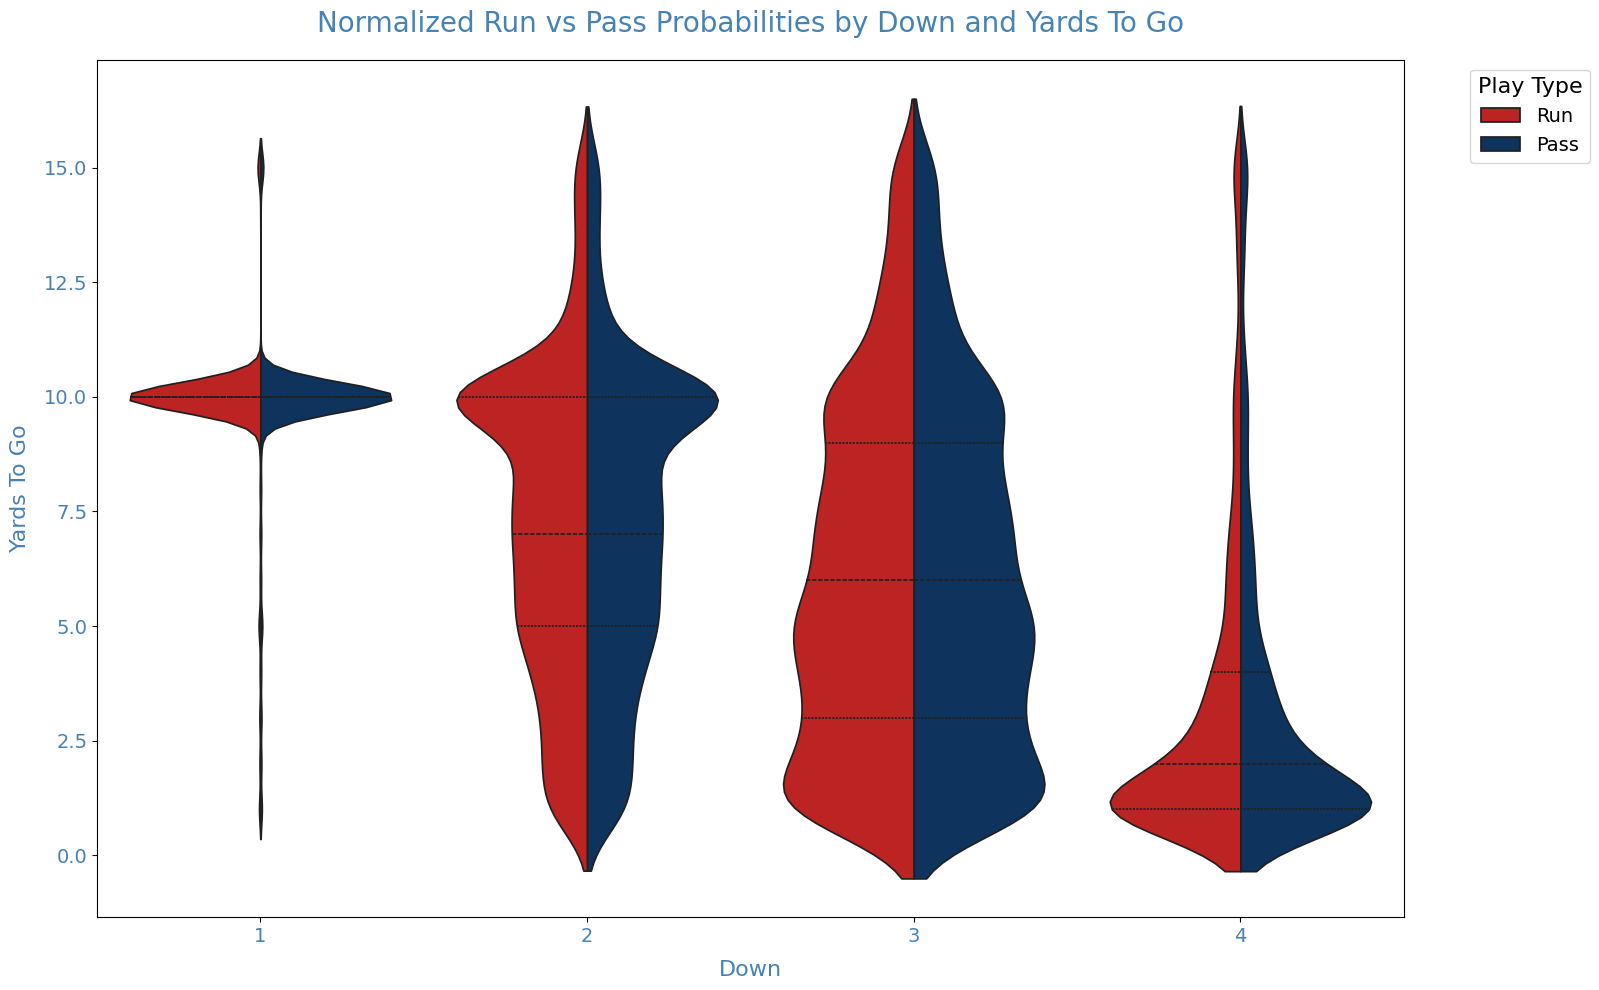

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter the data to limit yardsToGo to <= 15
filtered_data = updated_data[updated_data['yardsToGo'] <= 15].copy()

# Calculate probabilities explicitly
filtered_data['run_probability'] = filtered_data['target_rush']
filtered_data['pass_probability'] = 1 - filtered_data['target_rush']

# Melt the data to create long format for Seaborn
melted_data = filtered_data.melt(
    id_vars=['down', 'yardsToGo'],
    value_vars=['run_probability', 'pass_probability'],
    var_name='play_type',
    value_name='probability'
)

# Map play types to more user-friendly labels
melted_data['play_type_label'] = melted_data['play_type'].map(
    {'run_probability': 'Run', 'pass_probability': 'Pass'}
)

# Define colors for the play types
play_type_colors = {'Run': nfl_red, 'Pass': nfl_blue}

# Create split violin plot with normalized probabilities
plt.figure(figsize=(16, 10))
sns.violinplot(
    data=melted_data,
    x='down',
    y='yardsToGo',
    hue='play_type_label',  # Use friendly labels
    split=True,
    scale="width",  # Keep consistent scaling
    inner="quart",
    bw=0.2,  # Bandwidth for smoothing
    palette=play_type_colors  # Updated to match new labels
)

# Add titles and labels
plt.title('Normalized Run vs Pass Probabilities by Down and Yards To Go', fontsize=20, color='steelblue', pad=20)
plt.xlabel('Down', fontsize=16, color='steelblue', labelpad=10)
plt.ylabel('Yards To Go', fontsize=16, color='steelblue', labelpad=10)

# Customize ticks
plt.xticks(fontsize=14, color='steelblue')
plt.yticks(fontsize=14, color='steelblue')

# Adjust legend
plt.legend(title='Play Type', fontsize=14, title_fontsize=16, loc='upper right', bbox_to_anchor=(1.15, 1))

# Remove extra whitespace
plt.tight_layout()

# Show the plot
plt.show()


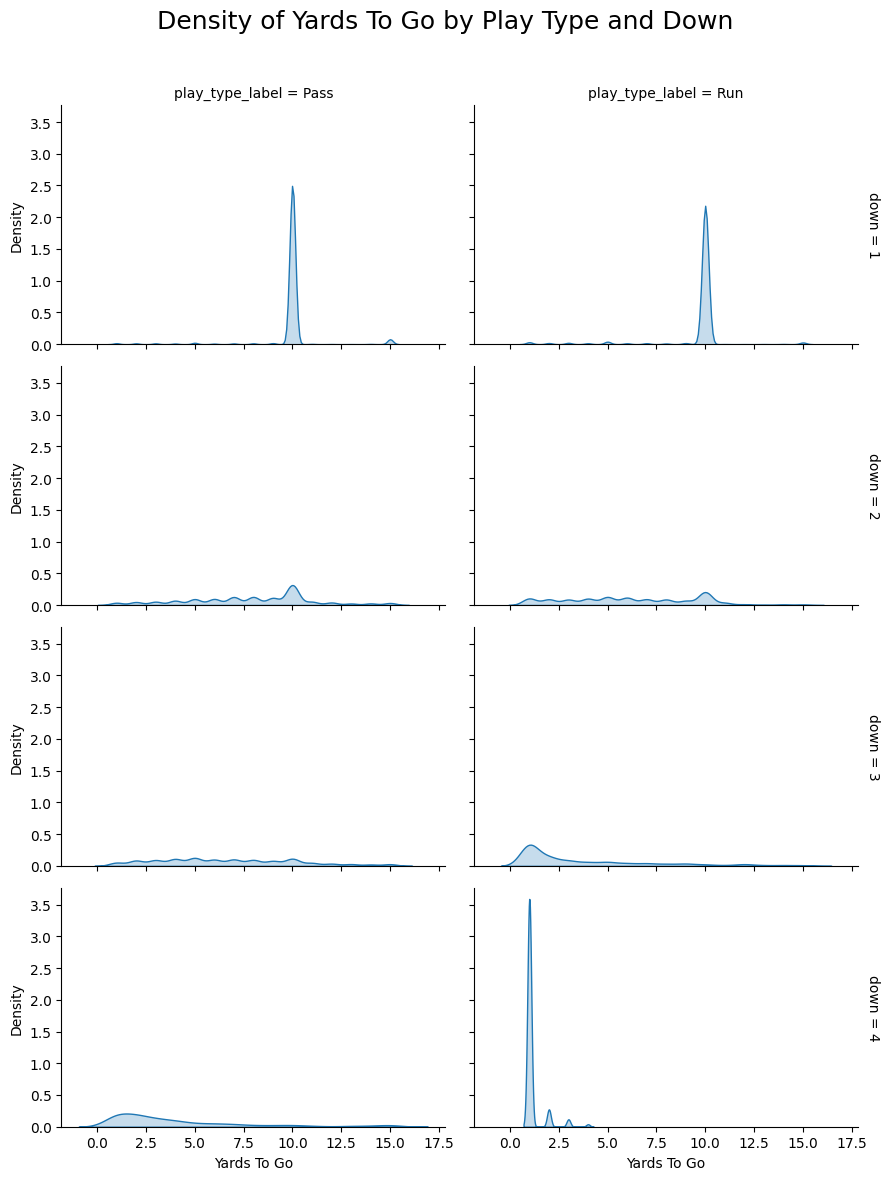

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette for play types
play_type_colors = {0: nfl_blue, 1: nfl_red}  # 0 (Pass) -> Blue, 1 (Run) -> Red

# Add human-readable labels for `target_rush`
filtered_data['play_type_label'] = filtered_data['target_rush'].replace({0: 'Pass', 1: 'Run'})

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_data,
    col="play_type_label",  # Use the human-readable play type labels
    row="down",
    margin_titles=True,
    height=3,
    aspect=1.5,
    palette=play_type_colors
)
g.map(sns.kdeplot, "yardsToGo", fill=True, bw_adjust=0.5)

# Set titles and labels
g.set_titles("{col_name} - Down {row_name}")
g.set_axis_labels("Yards To Go", "Density")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Density of Yards To Go by Play Type and Down", fontsize=18)

plt.show()



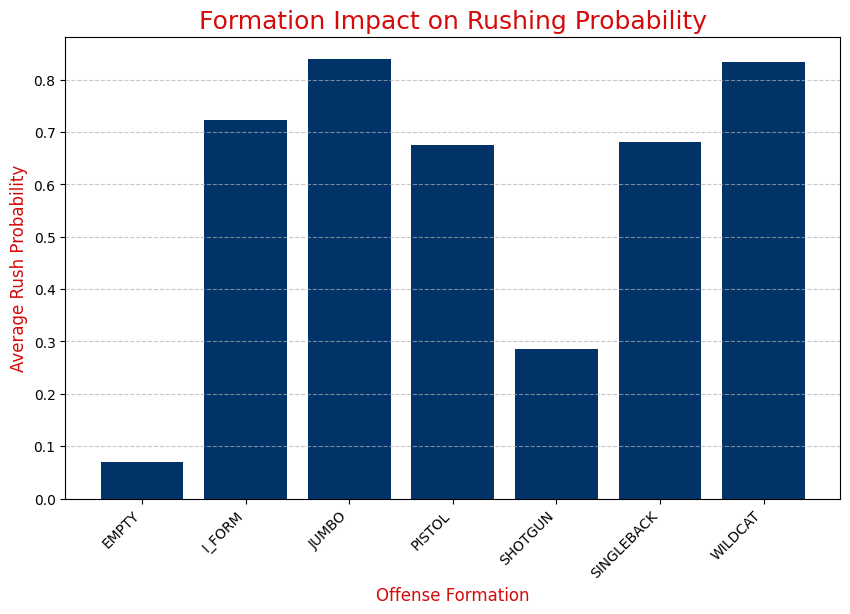

In [142]:
#Formation Impact on Rushing
plt.figure(figsize=(10, 6))
plt.bar(formation_analysis['offenseFormation'], formation_analysis['avg_rush_probability'], color=nfl_blue)
plt.title('Formation Impact on Rushing Probability', fontsize=18, color=nfl_red)
plt.xlabel('Offense Formation', fontsize=12, color=nfl_red)
plt.ylabel('Average Rush Probability', fontsize=12, color=nfl_red)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

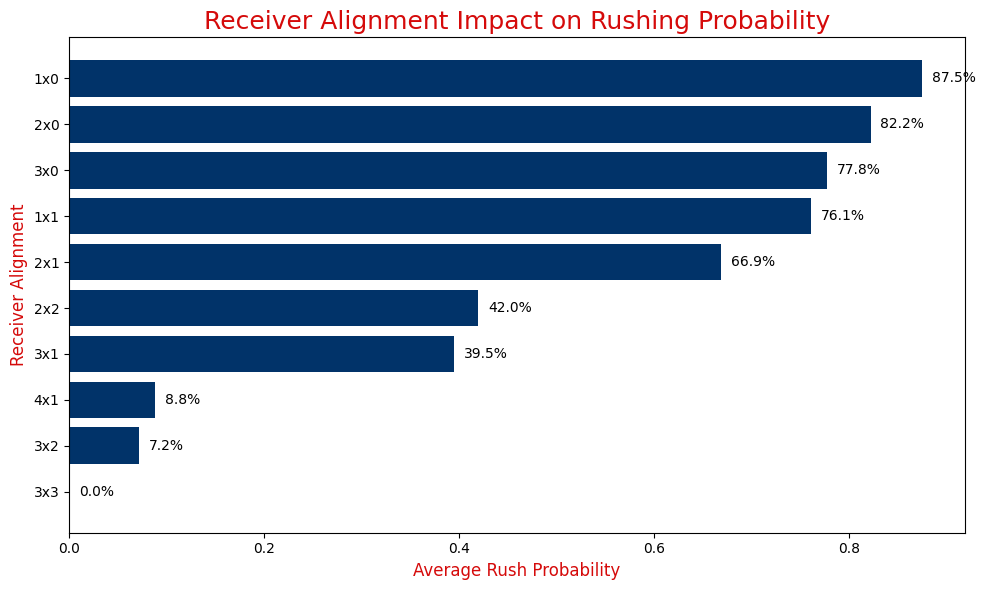

In [150]:
# Sort the DataFrame by 'avg_rush_probability' in descending order
alignment_analysis_sorted = alignment_analysis.sort_values(by='avg_rush_probability', ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(alignment_analysis_sorted['receiverAlignment'], alignment_analysis_sorted['avg_rush_probability'], color=nfl_blue)

# Add labels at the end of each bar
for index, value in enumerate(alignment_analysis_sorted['avg_rush_probability']):
    plt.text(
        value + 0.01,  # Slightly offset from the end of the bar
        index,  # y-coordinate (bar position)
        f"{value * 100:.1f}%",  # Format as percentage
        va='center',  # Vertically center the text
        fontsize=10,  # Font size of the text
        color='black'  # Text color
    )

# Title and labels
plt.title('Receiver Alignment Impact on Rushing Probability', fontsize=18, color=nfl_red)
plt.xlabel('Average Rush Probability', fontsize=12, color=nfl_red)
plt.ylabel('Receiver Alignment', fontsize=12, color=nfl_red)

# Remove the grid for a cleaner look
plt.grid(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-171-0a53dc7a4a94>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rb_depth_binned_analysis = aggregated_final_df.groupby('rb_depth_binned')['target_rush'].mean().reset_index()


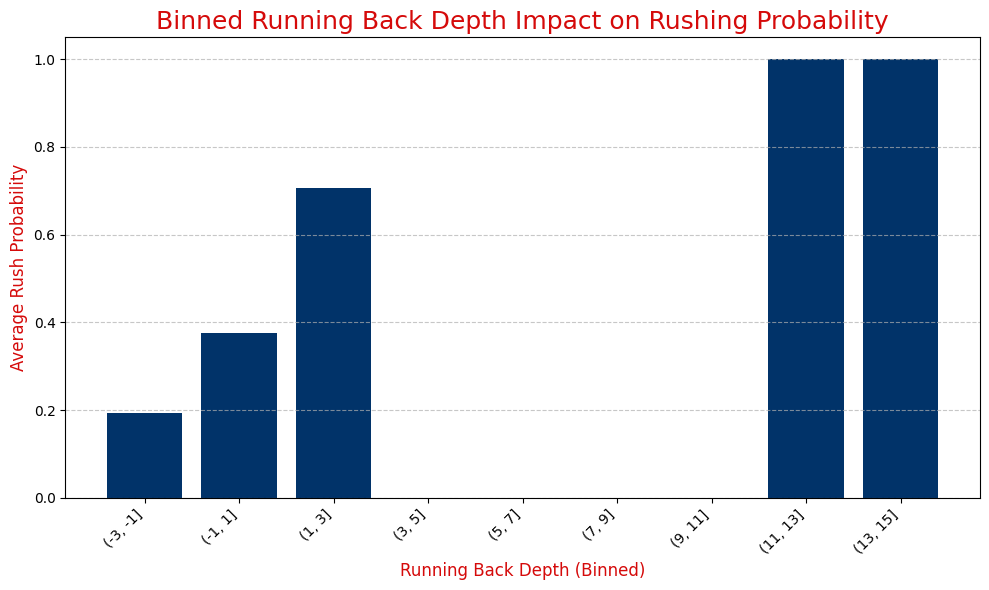

In [171]:
# Bin the 'rb_depth' values into intervals for better visualization
bins = np.arange(
    int(aggregated_final_df['rb_depth'].min()),
    int(aggregated_final_df['rb_depth'].max()) + 2, 2
)
aggregated_final_df['rb_depth_binned'] = pd.cut(aggregated_final_df['rb_depth'], bins)

# Recalculate average rushing probability for each bin
rb_depth_binned_analysis = aggregated_final_df.groupby('rb_depth_binned')['target_rush'].mean().reset_index()
rb_depth_binned_analysis.rename(columns={'target_rush': 'avg_rush_probability'}, inplace=True)

# Visualize the binned data
plt.figure(figsize=(10, 6))
plt.bar(
    rb_depth_binned_analysis['rb_depth_binned'].astype(str),
    rb_depth_binned_analysis['avg_rush_probability'],
    color=nfl_blue
)
plt.title('Binned Running Back Depth Impact on Rushing Probability', fontsize=18, color=nfl_red)
plt.xlabel('Running Back Depth (Binned)', fontsize=12, color=nfl_red)
plt.ylabel('Average Rush Probability', fontsize=12, color=nfl_red)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-170-e87def814167>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['rb_depth_binned'] = pd.cut(filtered_df['rb_depth'], bins)
<ipython-input-170-e87def814167>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rb_depth_binned_analysis = filtered_df.groupby('rb_depth_binned', as_index=False).agg(


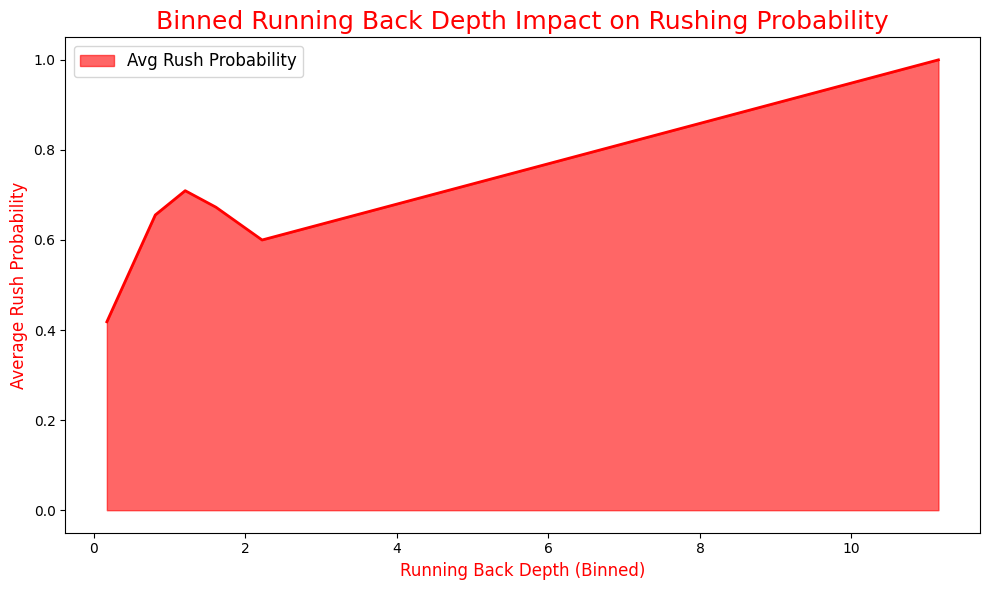

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out records where rb_depth is less than 0
filtered_df = aggregated_final_df[aggregated_final_df['rb_depth'] >= 0]

# Define smaller bins for running back depth
bins = np.arange(
    int(filtered_df['rb_depth'].min()),
    int(filtered_df['rb_depth'].max()) + 0.5, 0.5  # Small bin intervals (0.5)
)

# Bin the rb_depth values
filtered_df['rb_depth_binned'] = pd.cut(filtered_df['rb_depth'], bins)

# Calculate average rushing probability for each bin
rb_depth_binned_analysis = filtered_df.groupby('rb_depth_binned', as_index=False).agg(
    avg_rush_probability=('target_rush', 'mean'),
    bin_midpoint=('rb_depth', 'mean')  # Use bin midpoints for smooth x-axis
)

# Sort by bin_midpoint to ensure the line plot flows correctly
rb_depth_binned_analysis = rb_depth_binned_analysis.sort_values(by='bin_midpoint')

# Plot as a connected line graph with an area chart
plt.figure(figsize=(10, 6))

# Area chart
plt.fill_between(
    rb_depth_binned_analysis['bin_midpoint'],
    rb_depth_binned_analysis['avg_rush_probability'],
    color='red', alpha=0.6, label='Avg Rush Probability'
)

# Line graph for clarity
plt.plot(
    rb_depth_binned_analysis['bin_midpoint'],
    rb_depth_binned_analysis['avg_rush_probability'],
    color='red', linewidth=2
)

# Add titles and labels
plt.title('Binned Running Back Depth Impact on Rushing Probability', fontsize=18, color='red')
plt.xlabel('Running Back Depth (Binned)', fontsize=12, color='red')
plt.ylabel('Average Rush Probability', fontsize=12, color='red')

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add grid for readability
plt.grid(False)

# Add legend
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
